In [38]:
initial_investment = 1000000
yearly_sale_percentage = 0.04
capital_gains_tax = 0.26
dividend_tax = 0.26
monthly_sale_percentage = yearly_sale_percentage / 12
ticker = 'VTI'

In [39]:
import pandas as pd

def load_source_data(prices_file, bigmac_file):
    # Stock prices
    ts = pd.read_csv(prices_file)
    ts = ts.sort_values(by="timestamp")
    ts = ts.reset_index()
    ts = ts.drop(columns="index")
    df = pd.DataFrame({
    "timestamp": ts["timestamp"],
    "price": ts["adjusted close"],
    "dividend": ts["dividend amount"],
    })
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Big Mac index
    bigmac_pricedata = pd.read_csv(bigmac_file)
    country = "United States"
    bmprice = bigmac_pricedata[bigmac_pricedata.name == country][['date', 'dollar_price']]
    bmprice['date'] = pd.to_datetime(bmprice['date'])
    bmprice.rename(columns={"date": "timestamp", "dollar_price": "cpi"}, inplace=True)
    
    # Discard data that is not in the same time range for both datasets
    bmprice = bmprice[(bmprice['timestamp'] >= df['timestamp'].iloc[0]) & (bmprice['timestamp'] <= df['timestamp'].iloc[-1])]
    df = df[(df['timestamp'] >= bmprice['timestamp'].iloc[0]) & (df['timestamp'] <= bmprice['timestamp'].iloc[-1])]
    
    # Merge datasets
    df = pd.merge_asof(df, bmprice, on="timestamp")
    # Dividend per dollar
    df['dividend yield'] = df['dividend'] / df['price']
    # Normalize CPI to 1 and stock price to 100
    df['cpi'] = df['cpi'].fillna(bmprice['cpi'].iloc[0])
    df['cpi'] = (df['cpi'] / df['cpi'].iloc[0]).round(3)
    df['price'] = (df['price'] / df['price'].iloc[0] * 100).round(3)
    # Dividend per share
    df['dividend'] = (df['dividend yield'] * df['price']).round(3)
    return df

In [40]:
src = load_source_data(f"monthly_adjusted_{ticker}.csv", "bigmac.csv")
src

,timestamp,price,dividend,cpi,dividend yield
0,2002-04-30,100.000,0.000,1.000,0.000000
1,2002-05-31,98.570,0.000,1.000,0.000000
2,2002-06-28,91.774,0.763,1.000,0.008312
3,2002-07-31,84.120,0.000,1.000,0.000000
4,2002-08-30,84.763,0.000,1.000,0.000000
...,...,...,...,...,...
238,2022-02-28,628.439,0.000,2.145,0.000000
239,2022-03-31,648.955,2.078,2.145,0.003202
240,2022-04-29,589.694,0.000,2.145,0.000000
241,2022-05-31,588.212,0.000,2.145,0.000000


In [18]:
df = src.copy()
initial_shares = initial_investment / df['price'].iloc[0]
initial_price = df['price'].iloc[0]
initial_price, initial_shares
df['shares'] = initial_shares
df['perc. sold'] = monthly_sale_percentage
df['net dividend yield'] = df['dividend yield'] * (1 - dividend_tax)
# This model assumes we reinvest the entire post-tax dividend, then sell the fixed monthly percentage of the portfolio according to the yearly sale schedule of 4%
# This means that net stock sales can be negative, which means we are buying stocks, because the dividend yield is higher than the sale percentage
# We use gross stock sales to calculate our revenue, but only net stock sales contribute to capital gains tax, because we only pay tax on the profit
# The difference between gross and net stock sales is the amount of stock we bought with the dividend, and the dividend tax is calculated on the gross dividend before reinvestment
df['shares'] = (df['shares'] * (1 - (df['perc. sold'] - df['net dividend yield'])).cumprod()).round(2)
df['shares sold'] = (df['shares'].shift(1).fillna(initial_shares) * df['perc. sold']).round(2)
df['net shares sold'] = (df['shares'].shift(1).fillna(initial_shares) - df['shares']).round(3)
df['portfolio value'] = (df['shares'] * df['price']).round(2)
df['total port change'] = ((df['portfolio value'] / initial_investment)).round(4)
df['monthly value inc'] = (df['portfolio value'] - df['portfolio value'].shift(1).fillna(initial_investment)).round(2)
df['inflation adj. value'] = (df['portfolio value'] / df['cpi']).round(2)
df['infl. adj. port change'] = ((df['portfolio value'] / df['cpi'] / initial_investment)).round(4)
df['shares sold value'] = (df['shares sold'] * df['price']).round(2)

# Capital gains tax is calculated on the profit from net selling of stocks, not on the entire sale value.
# We clip the net sales to 0, so we don't pay tax on buying stocks
df['capital gains'] = ((df['price'] - initial_price) * df['net shares sold'].clip(lower=0)).round(2)
df['capital gains tax'] = (df['capital gains'] * capital_gains_tax).round(2)
#df['tax %'] = (df['capital gains tax'] / df['shares sold value']).round(4)
df['net income'] = (df['shares sold'] * df['price'] - df['capital gains tax']).round(2)
df['dividend tax'] = (df['shares'] * df['dividend'] * dividend_tax).round(2)
df['total dividends'] = (df['shares'] * df['dividend']).round(2)
df['infl. adj. income'] = (df['net income'] / df['cpi']).round(2)
df['infl. adj. income change'] = ((df['infl. adj. income'] / df['infl. adj. income'].iloc[0])).round(4)
df

,timestamp,price,dividend,cpi,dividend yield,shares,perc. sold,net dividend yield,shares sold,net shares sold,...,inflation adj. value,infl. adj. port change,shares sold value,capital gains,capital gains tax,net income,dividend tax,total dividends,infl. adj. income,infl. adj. income change
0,2002-04-30,100.000,0.000,1.000,0.000000,9966.67,0.003333,0.000000,33.33,33.33,...,996667.00,0.9967,3333.00,0.00,0.00,3333.00,0.00,0.00,3333.00,1.0000
1,2002-05-31,98.570,0.000,1.000,0.000000,9933.44,0.003333,0.000000,33.22,33.23,...,979139.18,0.9791,3274.50,-47.52,-12.36,3286.86,0.00,0.00,3286.86,0.9862
2,2002-06-28,91.774,0.763,1.000,0.008312,9961.44,0.003333,0.006151,33.11,-28.00,...,914201.19,0.9142,3038.64,-0.00,-0.00,3038.64,1976.15,7600.58,3038.64,0.9117
3,2002-07-31,84.120,0.000,1.000,0.000000,9928.23,0.003333,0.000000,33.20,33.21,...,835162.71,0.8352,2792.78,-527.37,-137.12,2929.90,0.00,0.00,2929.90,0.8791
4,2002-08-30,84.763,0.000,1.000,0.000000,9895.14,0.003333,0.000000,33.09,33.09,...,838741.75,0.8387,2804.81,-504.19,-131.09,2935.90,0.00,0.00,2935.90,0.8809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2022-02-28,628.439,0.000,2.145,0.000000,6994.96,0.003333,0.000000,23.39,23.40,...,2049373.27,2.0494,14699.19,12365.47,3215.02,11484.17,0.00,0.00,5353.93,1.6063
239,2022-03-31,648.955,2.078,2.145,0.003202,6988.22,0.003333,0.002369,23.32,6.74,...,2114237.91,2.1142,15133.63,3699.96,961.99,14171.64,3775.60,14521.52,6606.83,1.9822
240,2022-04-29,589.694,0.000,2.145,0.000000,6964.93,0.003333,0.000000,23.29,23.29,...,1914768.03,1.9148,13733.97,11404.97,2965.29,10768.68,0.00,0.00,5020.36,1.5063
241,2022-05-31,588.212,0.000,2.145,0.000000,6941.71,0.003333,0.000000,23.22,23.22,...,1903588.40,1.9036,13658.28,11336.28,2947.43,10710.85,0.00,0.00,4993.40,1.4982


In [20]:
period_months = 12

In [21]:
dfs = [df[i:i+period_months] for i in range(0, df.shape[0], period_months)]
dfs = [df for df in dfs if df.shape[0] == period_months]

In [32]:
yearly = pd.DataFrame({
    "timestamp": [d["timestamp"].iloc[-1] for d in dfs],
    "price": [d["price"].iloc[-1] for d in dfs],
    "cpi": [d["cpi"].iloc[-1] for d in dfs],
    "shares": [d["shares"].iloc[-1] for d in dfs],
    "shares sold": [d["shares sold"].sum() for d in dfs],
    "portfolio value": [d["portfolio value"].iloc[-1] for d in dfs],
    "total port change": [d["total port change"].iloc[-1] for d in dfs],
    "inflation adj. value": [d["inflation adj. value"].iloc[-1] for d in dfs],
    "infl. adj. port change": [d["infl. adj. port change"].iloc[-1] for d in dfs],
    "dividend yield_t": [d['total dividends'].sum() / d["portfolio value"].iloc[-1] for d in dfs],
    "dividend yield": [d['dividend yield'].sum() for d in dfs],
    "dividend tax": [d["dividend tax"].sum() for d in dfs],
    "income": [d["shares sold value"].sum() for d in dfs],
    "cap. gains tax": [d["capital gains"].sum() * capital_gains_tax for d in dfs],
})
yearly

,timestamp,price,cpi,shares,shares sold,portfolio value,total port change,inflation adj. value,infl. adj. port change,dividend yield_t,dividend yield,dividend tax,income,cap. gains tax
0,2003-03-31,79.498,1.000,9931.45,397.24,789530.41,0.7895,789530.41,0.7895,0.046275,0.044892,9499.22,33941.58,-902.3872
1,2004-03-31,110.978,1.047,9836.11,394.47,1091591.82,1.0916,1042590.09,1.0426,0.037992,0.041129,10782.65,39646.55,-14.5782
2,2005-03-31,118.714,1.051,9805.41,391.26,1164039.44,1.1640,1107554.18,1.1076,0.049210,0.050005,14893.47,44578.33,887.2370
3,2006-03-31,136.407,1.136,9771.50,390.17,1332901.00,1.3329,1173328.35,1.1733,0.046726,0.049530,16192.94,49493.59,1766.8664
4,2007-03-30,151.481,1.230,9731.81,388.83,1474184.31,1.4742,1198523.83,1.1985,0.046293,0.048702,17743.44,55364.89,2825.9114
5,2008-03-31,142.828,1.277,9695.35,387.08,1384767.45,1.3848,1084391.11,1.0844,0.053579,0.049135,19290.73,60447.01,3778.7646
6,2009-03-31,88.427,1.366,9540.83,383.80,843666.97,0.8437,617618.57,0.6176,0.040760,0.032425,8940.94,45366.54,1343.7528
7,2010-03-31,135.802,1.460,9341.75,377.42,1268628.33,1.2686,868923.51,0.8689,0.023184,0.025626,7646.99,44362.72,1002.0504
8,2011-03-31,159.659,1.502,9142.61,369.57,1459699.97,1.4597,971837.53,0.9718,0.022135,0.025001,8400.83,51572.48,2488.9072
9,2012-03-30,171.205,1.621,8941.71,361.45,1530865.46,1.5309,944395.72,0.9444,0.021733,0.024093,8650.31,56439.98,3576.5626


In [33]:
yearly["net income"] = yearly["income"] - yearly["cap. gains tax"].clip(lower=0)
yearly['infl. adj. income'] = (yearly['net income'] / yearly['cpi']).round(2)
yearly['infl. adj. monthly income'] = (yearly['infl. adj. income'] / period_months).round(2)
yearly['infl. adj. monthly income change'] = (yearly['infl. adj. monthly income'] / yearly['infl. adj. monthly income'].iloc[0]).round(4)
yearly['tax to gross income ratio'] = ((yearly['dividend tax'] + yearly['cap. gains tax']) / yearly['income']).round(4)
yearly

,timestamp,price,cpi,shares,shares sold,portfolio value,total port change,inflation adj. value,infl. adj. port change,dividend yield_t,dividend yield,dividend tax,income,cap. gains tax,net income,infl. adj. income,infl. adj. monthly income,infl. adj. monthly income change,tax to gross income ratio
0,2003-03-31,79.498,1.000,9931.45,397.24,789530.41,0.7895,789530.41,0.7895,0.046275,0.044892,9499.22,33941.58,-902.3872,33941.5800,33941.58,2828.46,1.0000,0.2533
1,2004-03-31,110.978,1.047,9836.11,394.47,1091591.82,1.0916,1042590.09,1.0426,0.037992,0.041129,10782.65,39646.55,-14.5782,39646.5500,37866.81,3155.57,1.1156,0.2716
2,2005-03-31,118.714,1.051,9805.41,391.26,1164039.44,1.1640,1107554.18,1.1076,0.049210,0.050005,14893.47,44578.33,887.2370,43691.0930,41570.97,3464.25,1.2248,0.3540
3,2006-03-31,136.407,1.136,9771.50,390.17,1332901.00,1.3329,1173328.35,1.1733,0.046726,0.049530,16192.94,49493.59,1766.8664,47726.7236,42012.96,3501.08,1.2378,0.3629
4,2007-03-30,151.481,1.230,9731.81,388.83,1474184.31,1.4742,1198523.83,1.1985,0.046293,0.048702,17743.44,55364.89,2825.9114,52538.9786,42714.62,3559.55,1.2585,0.3715
5,2008-03-31,142.828,1.277,9695.35,387.08,1384767.45,1.3848,1084391.11,1.0844,0.053579,0.049135,19290.73,60447.01,3778.7646,56668.2454,44376.07,3698.01,1.3074,0.3816
6,2009-03-31,88.427,1.366,9540.83,383.80,843666.97,0.8437,617618.57,0.6176,0.040760,0.032425,8940.94,45366.54,1343.7528,44022.7872,32227.52,2685.63,0.9495,0.2267
7,2010-03-31,135.802,1.460,9341.75,377.42,1268628.33,1.2686,868923.51,0.8689,0.023184,0.025626,7646.99,44362.72,1002.0504,43360.6696,29699.09,2474.92,0.8750,0.1950
8,2011-03-31,159.659,1.502,9142.61,369.57,1459699.97,1.4597,971837.53,0.9718,0.022135,0.025001,8400.83,51572.48,2488.9072,49083.5728,32678.81,2723.23,0.9628,0.2112
9,2012-03-30,171.205,1.621,8941.71,361.45,1530865.46,1.5309,944395.72,0.9444,0.021733,0.024093,8650.31,56439.98,3576.5626,52863.4174,32611.61,2717.63,0.9608,0.2166


Text(0.5, 1.0, 'Tax to gross income ratio')

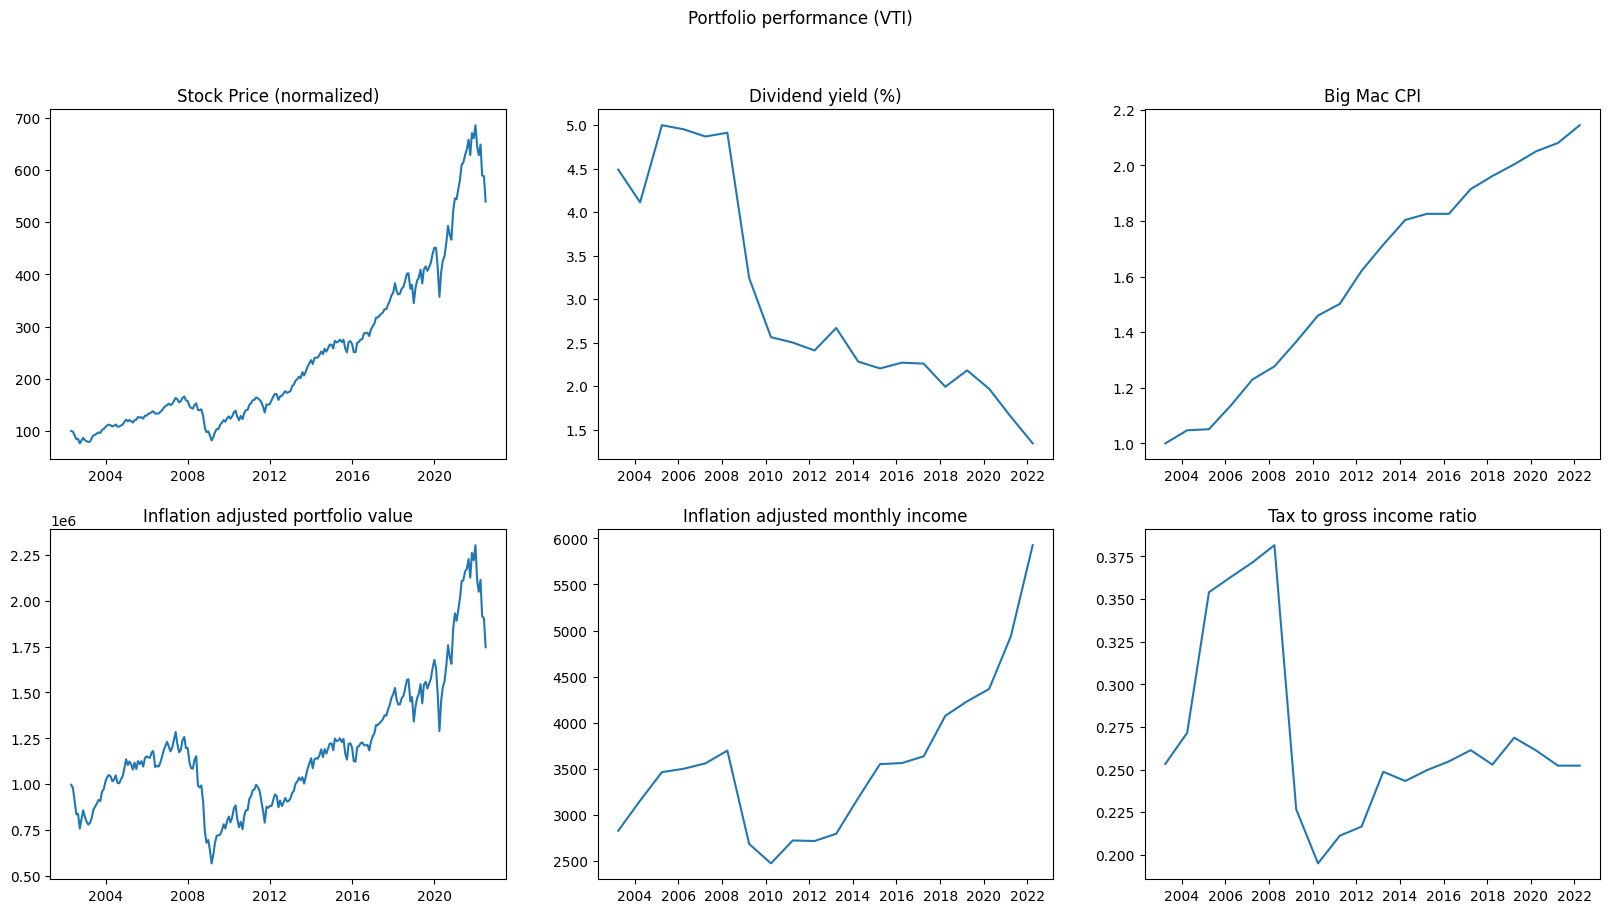

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))  # Adjust nrows and ncols based on the number of plots
fig.suptitle(f'Portfolio performance ({ticker})')
axs[0, 0].plot(df['timestamp'], df['price'])
axs[0, 0].set_title('Stock Price (normalized)')
axs[0, 1].plot(yearly['timestamp'], yearly['dividend yield'] * 100)
axs[0, 1].set_title('Dividend yield (%)')

axs[0, 2].plot(yearly['timestamp'], yearly['cpi'])
axs[0, 2].set_title('Big Mac CPI')

axs[1, 0].plot(df['timestamp'], df['inflation adj. value'])
axs[1, 0].set_title('Inflation adjusted portfolio value')

axs[1, 1].plot(yearly['timestamp'], yearly['infl. adj. monthly income'])
axs[1, 1].set_title('Inflation adjusted monthly income')

axs[1, 2].plot(yearly['timestamp'], yearly['tax to gross income ratio'])
axs[1, 2].set_title('Tax to gross income ratio')